# AD IMPACT ANALYSIS   Project
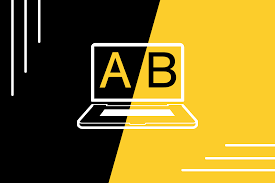

### Data Source: 
  [marketing_AB.csv](https://www.kaggle.com/code/chenwei17557/rfm-customer-segmentation-and-3d-visualization/output?select=marketing_AB.csv)

  ### Data Dictionary:
  **Index**: Chỉ số dòng

  **user id**: Mã người dùng (duy nhất)

  **test group**: Nếu là **"ad"** thì người đó **đã xem quảng cáo**, nếu là **"psa"** (public service announcement) thì họ **chỉ xem thông báo dịch vụ cộng đồng**

  **converted**: Nếu người đó mua sản phẩm thì là True, ngược lại là False

  **total ads**: Số lượng quảng cáo mà người đó **đã xem**

  **most ads day**: Ngày mà người đó xem số lượng quảng cáo lớn nhất

  **most ads hour**: Giờ trong ngày mà người đó xem số lượng quảng cáo lớn nhất
  
### Introduce:
Các công ty tiếp thị muốn thực hiện các chiến dịch thành công, nhưng thị trường rất phức tạp và có nhiều lựa chọn có thể hiệu quả. Vì vậy, thông thường họ điều chỉnh các thử nghiệm A/B, đó là một quy trình thử nghiệm ngẫu nhiên trong đó hai hoặc nhiều phiên bản của một biến (trang web, thành phần trang, biểu ngữ, v.v.) được hiển thị cho các phân khúc người khác nhau cùng một lúc để xác định phiên bản nào để lại tác động tối đa và thúc đẩy các số liệu kinh doanh.

### Goal:
  - **Phân tích các nhóm, xác định xem quảng cáo có thành công hay không?**
  
  - **Việc hiển thị quảng cáo cho người dùng có dẫn đến việc mua sắm nhiều hơn không?**

In [1]:
# import Thư Viện
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [2]:
df = pd.read_csv('marketing_AB.csv')
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


## Data Cleaning

In [3]:
# Khám phá dữ liệu
print('Thông tin dữ liệu')
print(df.info())

print("\n Mô tả dữ liệu")
print(df.describe())

Thông tin dữ liệu
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB
None

 Mô tả dữ liệu
          Unnamed: 0       user id      total ads  most ads hour
count  588101.000000  5.881010e+05  588101.000000  588101.000000
mean   294050.000000  1.310692e+06      24.820876      14.469061
std    169770.279667  2.022260e+05      43.715181       4.834634
min         0.000000  9.000000e+05       1.000000       0.000000
25%    147025.000000  1.143190e+06       4.000000      11.000000
50%  

In [30]:
# Kiểm tra dữ liệu thiếu
missing_data = df.isnull().sum()
print(missing_data)

user_id          0
test_group       0
converted        0
total_ads        0
most_ads_day     0
most_ads_hour    0
dtype: int64


In [5]:
# Xử lý các giá trị bị trùng lặp
df.drop_duplicates(inplace = True)

df[df['user id'].duplicated()].count()

Unnamed: 0       0
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

In [6]:
# Chuẩn hóa dữ liệu
df.rename(columns = lambda x: x.strip().replace(" ","_"),inplace = True)

df.head(1)

,Unnamed:_0,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,0,1069124,ad,False,130,Monday,20


In [7]:
df.drop(columns=['Unnamed:_0'], inplace=True)


In [8]:
df.head(2)

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22


In [9]:
print(f'Rows: {df.shape[0]}')
print(f'Columns : {df.shape[1]}')
print(f'Features : {df.columns.tolist()}')
print(f'Missiing Values : {df.isnull().values.sum()}')
print(f'\n Unique Values : \n{df.nunique()}')

Rows: 588101
Columns : 6
Features : ['user_id', 'test_group', 'converted', 'total_ads', 'most_ads_day', 'most_ads_hour']
Missiing Values : 0

 Unique Values : 
user_id          588101
test_group            2
converted             2
total_ads           807
most_ads_day          7
most_ads_hour        24
dtype: int64


## Cân Bằng dữ liệu

Mục đích của việc cân bằng dữ liệu giữa hai nhóm (trong trường hợp này là nhóm "ad" và nhóm "psa") bằng cách thực hiện undersampling nhóm lớn hơn là để giải quyết vấn đề **mất cân bằng dữ liệu**. Việc có số lượng mẫu tương đương từ cả hai nhóm sẽ giúp đảm bảo rằng các kết quả phân tích hoặc mô hình hóa không bị thiên lệch bởi nhóm có nhiều mẫu hơn. 
1. **Cải thiện hiệu suất mô hình**:

2. **Đảm bảo tính công bằng và chính xác**:
 
3. **Cải thiện độ chính xác trong các chỉ số đánh giá**:

4. **Giảm thiểu sai lệch trong việc dự đoán**:
 
5. **Tăng cường tính đại diện của dữ liệu**:


In [10]:
from sklearn.utils import resample

# Tách dữ liệu thành hai nhóm : ad và psa
ad_group = df[df['test_group'] == 'ad']
psa_group = df[df['test_group'] == 'psa']

# undersampling nhóm ad để cân bằng số lượng với nhóm psa 
ad_undersampled = resample(ad_group, replace = False, n_samples = len(psa_group), random_state = 42)

#Kết hợp hai nhóm 
balanced_df = pd.concat([ad_undersampled, psa_group])

## EDA (Exploratory Data Analysis)

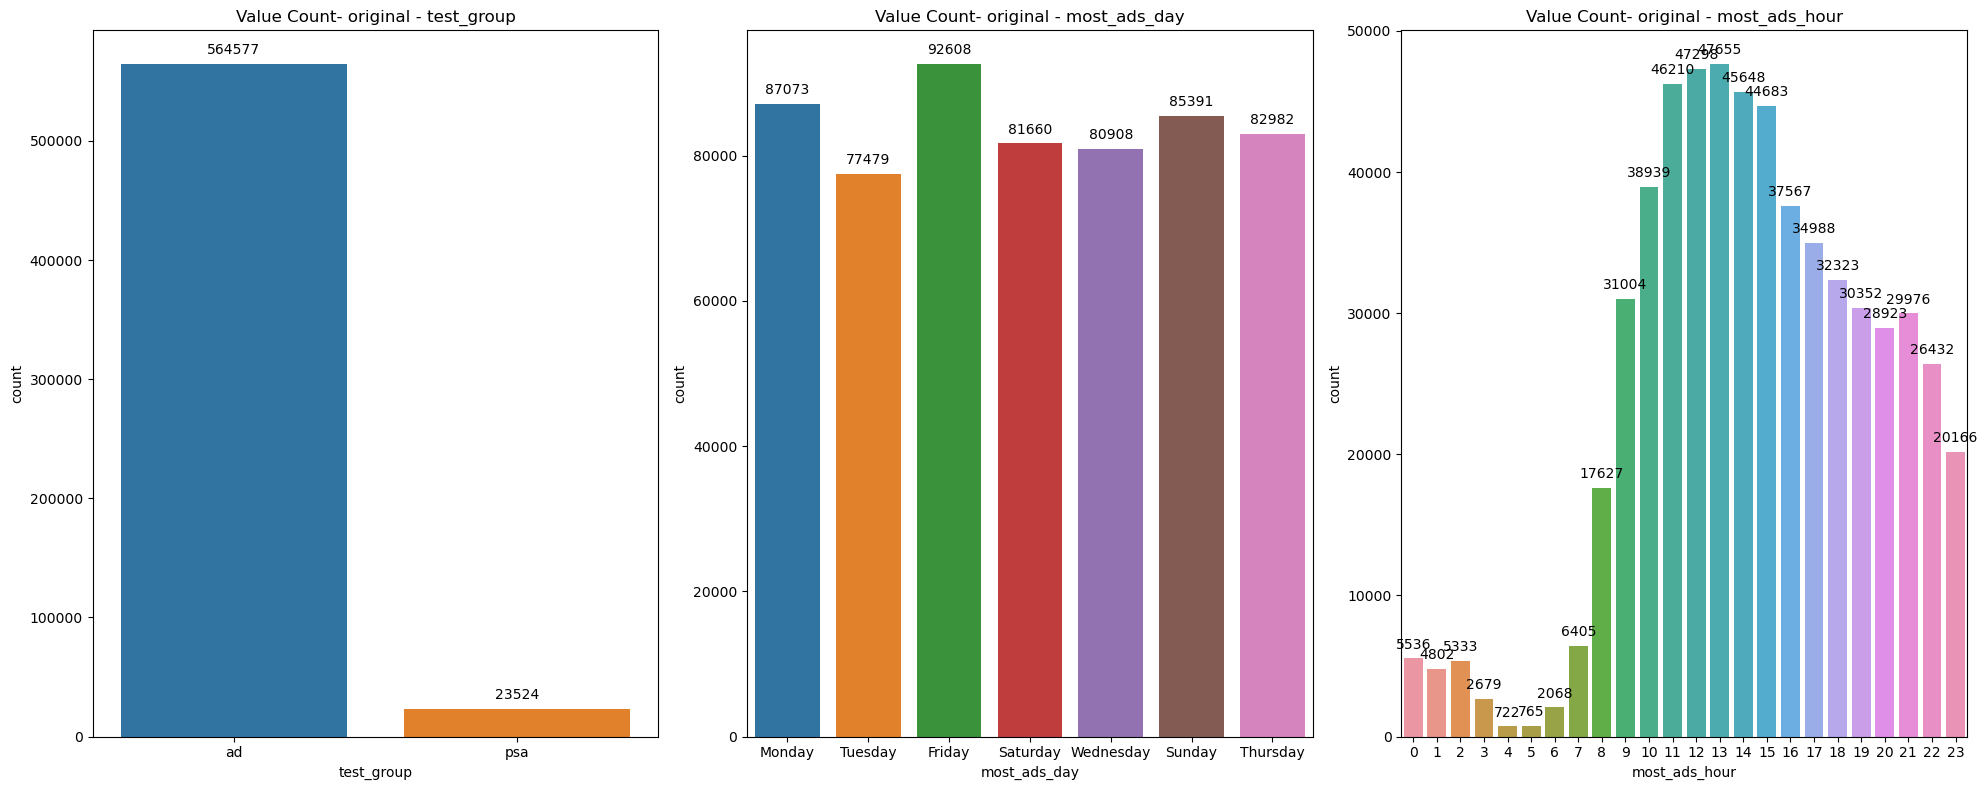

In [11]:
def val_count(column, position):
    ax = plt.subplot(1,3, position) # Tạo susplot 1 hàng , 3 cột
    sns.countplot(data = df, x= column, ax=ax) # Tạo biểu đồ đếm cho cột 
    plt.title(f'Value Count- original - {column}') # Đặt tiêu đề
    
    # Thêm chú thích lên thanh biểu đồ và làm tròn số nguyên
    for p in ax.patches:
        height = int(round(p.get_height())) # lấy chiều cao thanh làm tròn lên số nguyên
        ax.annotate(f'{height}', (p.get_x() + p.get_width()/2., height), # Vị trí thanh
                    ha = 'center', va= 'center', xytext = (0,10), textcoords = 'offset points') # Độ lệch, căn chỉnh
        

#Tạo danh sách cột
col_list = df.columns[[1,4,5]]

# Tạo figure với kích thước lớn để chứa biểu đồ
plt.figure(figsize = (20,8))

# Lặp qua từng cột trong danh sách và tạo biểu đồ đếm
for i, col in enumerate(col_list, start = 1):
    val_count(col, i)
    
# Điều chỉnh layout không bị chồng lên nhau
plt.tight_layout()
    
plt.show()

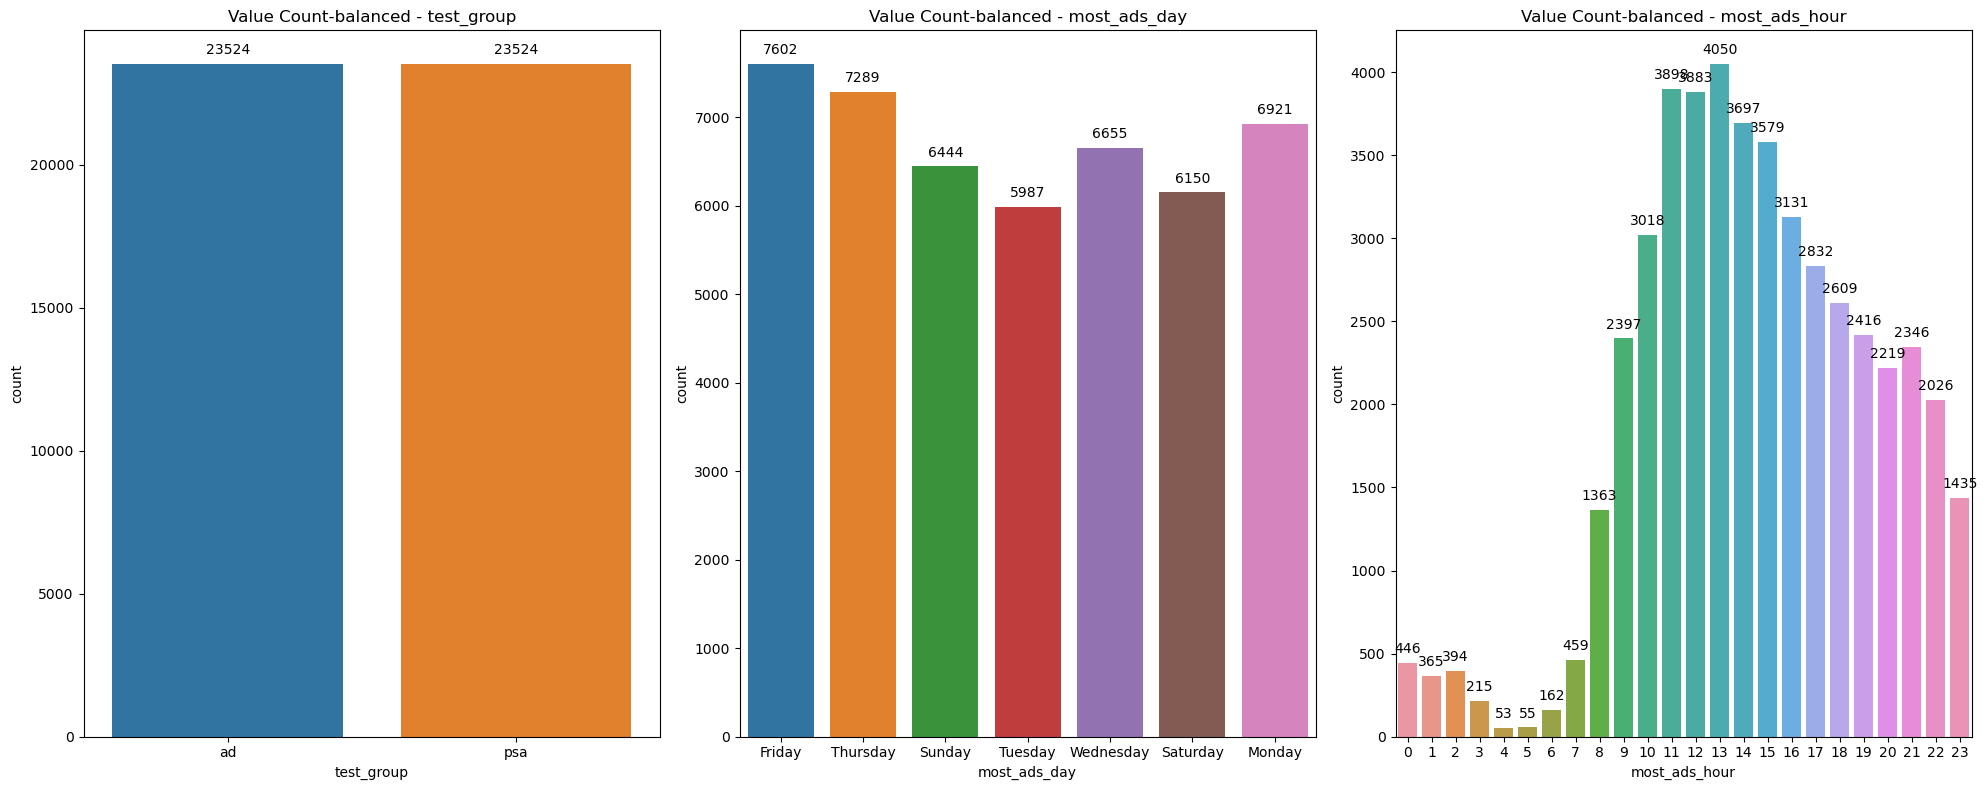

In [12]:
def val_count_balanced(column, position):
    ax = plt.subplot(1,3, position) # Tạo susplot 1 hàng , 3 cột
    sns.countplot(data = balanced_df, x= column, ax=ax) # Tạo biểu đồ đếm cho cột 
    plt.title(f'Value Count-balanced - {column}') # Đặt tiêu đề
    
    # Thêm chú thích lên thanh biểu đồ và làm tròn số nguyên
    for p in ax.patches:
        height = int(round(p.get_height())) # lấy chiều cao thanh làm tròn lên số nguyên
        ax.annotate(f'{height}', (p.get_x() + p.get_width()/2., height), # Vị trí thanh
                    ha = 'center', va= 'center', xytext = (0,10), textcoords = 'offset points') # Độ lệch, căn chỉnh
        

#Tạo danh sách cột
col_list_balanced = balanced_df.columns[[1,4,5]]

# Tạo figure với kích thước lớn để chứa biểu đồ
plt.figure(figsize = (20,8))

# Lặp qua từng cột trong danh sách và tạo biểu đồ đếm
for i, col in enumerate(col_list_balanced, start = 1):
    val_count_balanced(col, i)
    
# Điều chỉnh layout không bị chồng lên nhau
plt.tight_layout()
    
plt.show()

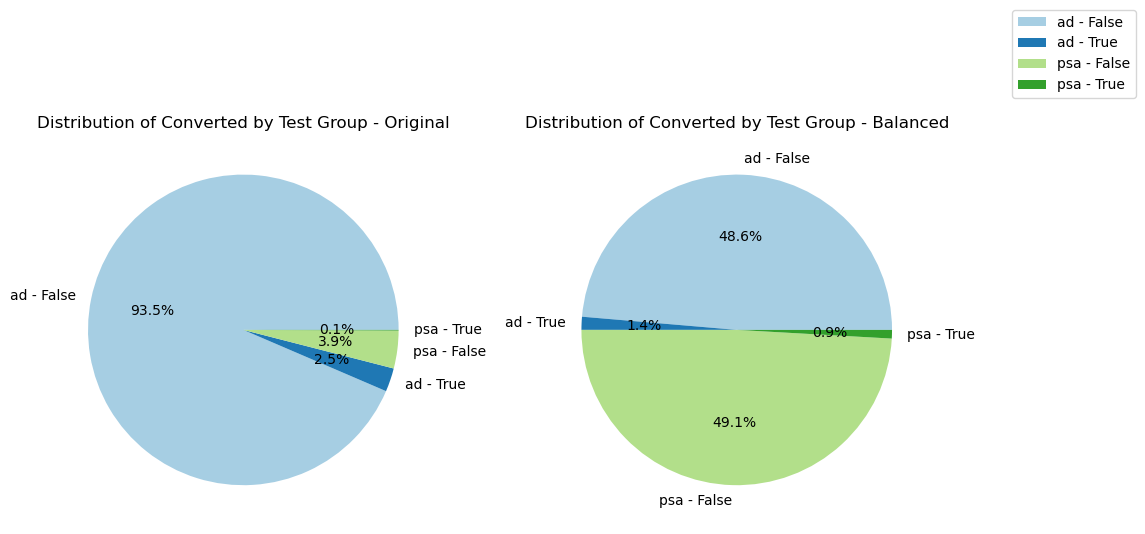

In [49]:
# Tính toán số lượng giá trị của từng nhóm
grouped_counts_df = df.groupby('test_group')['converted'].value_counts()
grouped_counts_balanced = balanced_df.groupby('test_group')['converted'].value_counts()

# Tạo subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Xác định các nhãn và màu sắc cho biểu đồ pie
labels = [f'{test_group} - {converted}' for test_group, converted in grouped_counts_df.index]
colors = plt.cm.Paired(range(len(labels)))  # Sử dụng màu từ colormap 'Paired'

# Đồ thị data dạng pie cho df
axes[0].pie(grouped_counts_df, labels=labels, colors=colors, autopct='%1.1f%%')
axes[0].set_title('Distribution of Converted by Test Group - Original')

# Đồ thị data dạng pie cho balanced_df
labels_balanced = [f'{test_group} - {converted}' for test_group, converted in grouped_counts_balanced.index]
axes[1].pie(grouped_counts_balanced, labels=labels_balanced, colors=colors, autopct='%1.1f%%')
axes[1].set_title('Distribution of Converted by Test Group - Balanced')

# Thêm chú thích cho cả hai biểu đồ
fig.legend(labels, loc='upper right', bbox_to_anchor=(1.15, 1.15))

plt.tight_layout()
plt.show()


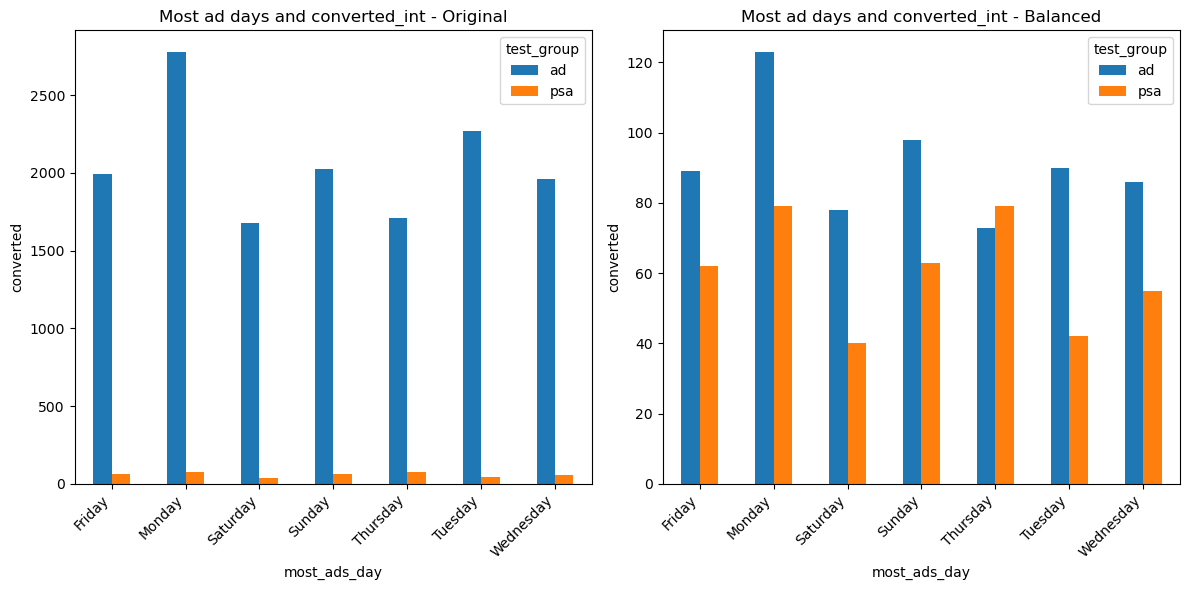

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Tạo subplot 1 hàng hai cột

# Đồ thị chuyển đổi của ad trong ngày cho df
ax_df = df.groupby(by=['most_ads_day', 'test_group']).sum()['converted'].unstack('test_group').plot(kind='bar', ax=axes[0])
ax_df.set_ylabel('converted')
ax_df.set_title('Most ad days and converted_int - Original')

# Đồ thị chuyển đổi của ad trong ngày cho balanced_df
ax_balanced = balanced_df.groupby(by=['most_ads_day', 'test_group']).sum()['converted'].unstack('test_group').plot(kind='bar', ax=axes[1])
ax_balanced.set_ylabel('converted')
ax_balanced.set_title('Most ad days and converted_int - Balanced')

# Nghiêng trục chú thích x
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


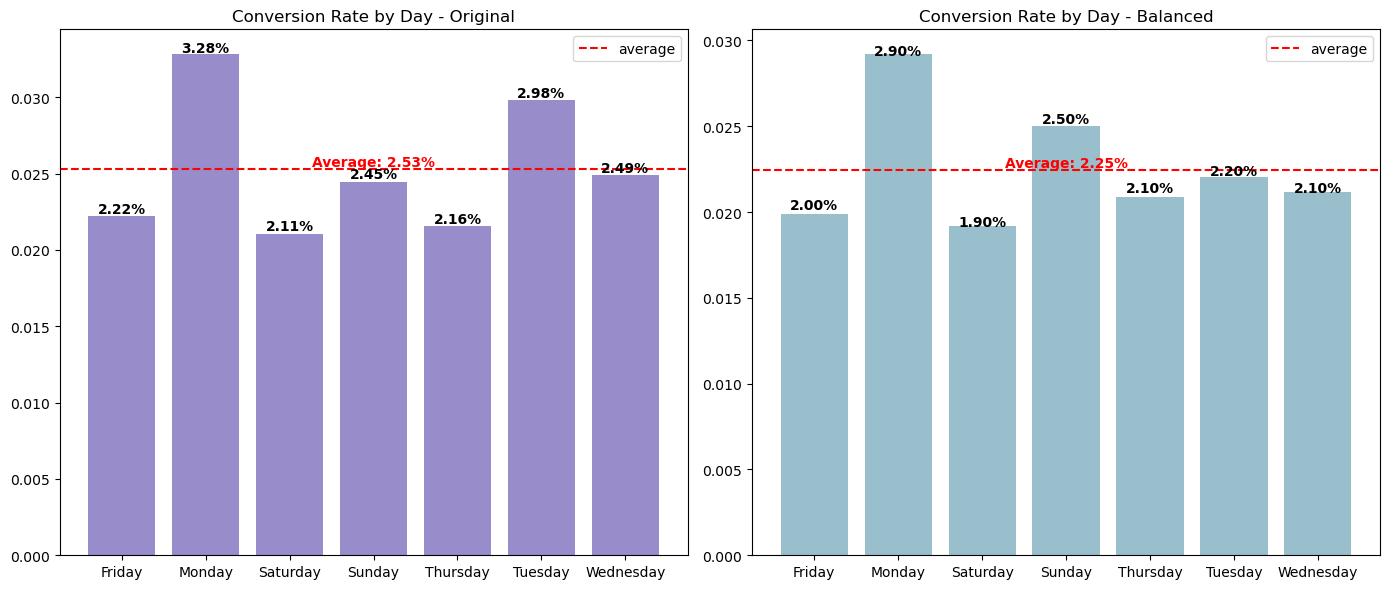

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Tạo subplot 1 hàng hai cột

# Trực quan sự chuyển đổi theo ngày - Original
df_day_conv = pd.DataFrame(df.groupby('most_ads_day')['converted'].mean())
df_day_conv.reset_index(inplace=True)
colors = (0.2, 0.1, 0.6, 0.5)

# Tạo đồ thị cột cho dữ liệu gốc
bars = axes[0].bar(df_day_conv['most_ads_day'], df_day_conv['converted'], color=colors)

# Thêm chú thích số cho từng cột
for bar in bars:
    height = round(bar.get_height(), 4)
    axes[0].text(bar.get_x() + bar.get_width() / 2, height,
                 f'{(height * 100):.2f}%', ha='center', va='bottom', color='black', fontweight='bold')

# Thêm dòng trung bình
average_value = df_day_conv['converted'].mean()
axes[0].axhline(average_value, color='r', linestyle='--', label='average')

# Thêm chú thích cho dòng trung bình ở giữa
middle_index = len(df_day_conv['most_ads_day']) // 2
axes[0].text(middle_index, average_value, f'Average: {average_value:.2%}', color='r', ha='center', va='bottom', fontweight='bold')

axes[0].set_title('Conversion Rate by Day - Original')
axes[0].legend()

# Trực quan sự chuyển đổi theo ngày - Balanced
df_day_conv_balanced = pd.DataFrame(balanced_df.groupby('most_ads_day')['converted'].mean())
df_day_conv_balanced.reset_index(inplace=True)
colors_balanced = (0.2, 0.5, 0.6, 0.5)

# Tạo đồ thị cột cho dữ liệu đã cân bằng
bars_balanced = axes[1].bar(df_day_conv_balanced['most_ads_day'], df_day_conv_balanced['converted'], color=colors_balanced)

# Thêm chú thích số cho từng cột
for bar in bars_balanced:
    height = round(bar.get_height(), 3)
    axes[1].text(bar.get_x() + bar.get_width() / 2, height,
                 f'{(height * 100):.2f}%', ha='center', va='bottom', color='black', fontweight='bold')

# Thêm dòng trung bình
average_value_balanced = df_day_conv_balanced['converted'].mean()
axes[1].axhline(average_value_balanced, color='r', linestyle='--', label='average')

# Thêm chú thích cho dòng trung bình ở giữa
middle_index_balanced = len(df_day_conv_balanced['most_ads_day']) // 2
axes[1].text(middle_index_balanced, average_value_balanced, f'Average: {average_value_balanced:.2%}', color='r', ha='center', va='bottom', fontweight='bold')

axes[1].set_title('Conversion Rate by Day - Balanced')
axes[1].legend()


plt.tight_layout()
plt.show()


## A/B TEST
  - **Phân tích các nhóm, xác định xem quảng cáo có thành công hay không?**


**Kích thước mẫu (n)**: 
- N : population_size : kích thước tổng dữ liệu
- z : confidence_level : mức độ tin cậy
- margin_of_error : biên độ sai số
- p: Xác suất thành công, giả định là 0.5 (giá trị phổ biến khi không có thông tin cụ thể).
- q: Xác suất thất bại, tính bằng 1 - p.

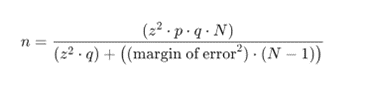

In [41]:

def sample_size_calculator(population_size, confidence_level, margin_of_error):
    z_score = {
        0.90 : 1.645,
        0.955 : 1.96,
        0.99 : 2.576
    }
    
    z = z_score[confidence_level]
    p = 0.5
    q = 1-p
    
    sample_size = ((z**2)*p*q*population_size) / ((z**2*q)+((margin_of_error**2))*(population_size-1))
    
    return math.ceil(sample_size)


In [45]:
# Tính kích thước mẫu
population_size =  balanced_df.shape[0]
confidence_level = 0.99
margin_of_error = 0.03

# Gọi hàm kích thước mẫu
sample_size = sample_size_calculator(population_size, confidence_level, margin_of_error)

print(f"The population size is: {population_size} \nThe sample size is : {sample_size}")

The population size is: 47048 
The sample size is : 1710


**Treatment Group:** (nhóm can thiệp) nhóm người (ad) thí nghiệm được tiếp xúc với yếu tố thử nghiệm hoặc thay đổi mới hiện thị quảng cáo. Mục tiêu là để xem liệu việc hiển thị quảng cáo có tăng tỷ lệ chuyển đổi hay không.

**Control Group:** (nhóm kiểm soát) nhóm người (psa) không tiếp xúc với yếu tố thử nghiệm hoặc thay đổi mới hiển thị quảng cáo dịch vụ công. Mục tiêu là để so sánh với nhóm "treatment" và đánh giá hiệu quả thực sự của quảng cáo.

In [46]:
df_treatment = df.query('test_group == "ad" ')
df_control   = df.query('test_group == "psa"')

balanced_treatment = balanced_df.query('test_group == "ad"')
balanced_control   = balanced_df.query('test_group == "psa"')


In [49]:
# Tỷ lệ chuyển đổi original và balanced

print("Total Original Converted Rate :  ",df.converted.mean()*100)
print("Total Balanced Converted Rate :  ",balanced_df.converted.mean()*100)

Total Original Converted Rate :   2.523886203220195
Total Balanced Converted Rate :   2.246641727597347


In [51]:
# Tỷ lệ chuyển đổi nhóm Control original and balanced

print("Orginal_Control_rate :  ", df_control["converted"].mean()*100)
print("Balanced_Control_rate:  ", balanced_control["converted"].mean()*100)

Orginal_Control_rate :   1.785410644448223
Balanced_Control_rate:   1.785410644448223


In [52]:
# Tỷ lệ chuyển đổi nhóm Treatment original and balanced

print("Original_Treatment_rate :  ", df_treatment["converted"].mean()*100)
print("Balanced_Treatment_rate :  ", balanced_treatment["converted"].mean()*100)

Original_Treatment_rate :   2.5546559636683748
Balanced_Treatment_rate :   2.707872810746472


**Sau phân tích có quan sát đáng chú ý:**
- Sự tăng nhẹ trong tỷ lệ chuyển đổi của nhóm Treatment khi cân bằng dữ liệu có thể cho thấy quảng cáo có tác động tích cực hơn trong điều kiện cân bằng. => **quảng cáo có thể thực sự đang ảnh hưởng lên hành vi người tiêu dùng.**
- Tỷ lệ chuyển đổi của nhóm Control không thay đổi, điều này cho thấy rằng sự thay đổi trong nhóm Treatment có thể do quảng cáo chứ không phải do yếu tố bên ngoài.

## Hypothesis_testing

**Việc hiển thị quảng cáo cho người dùng có dẫn đến việc mua sắm nhiều hơn không?**

* (H0): Việc hiển thị quảng cáo không có ảnh hưởng đáng kể đến số lượng mua sắm.
* (H1): Việc hiển thị quảng cáo có ảnh hưởng đáng kể đến số lượng mua sắm.

**Phương pháp: T-test**

In [77]:

# 1. hai mảng dữ liệu: treatment và control df.
treatment_df = df.query('test_group == "ad"')['converted']
control_df = df.query('test_group == "psa"')['converted']

# Thực hiện kiểm định t-test
t_stat_df, p_value_df = stats.ttest_ind(treatment_df, control_df)

print(f"T-statistic_df: {t_stat_df}")
print(f"P-value_df: {p_value_df}")

# So sánh kết quả với df
if p_value_df < 0.05:
    print("Data Original: There is a significant difference between the ad group and the psa group.")
else:
    print("Data Original: There is no significant difference between the ad group and the psa group.")

    
# 2. hai mảng dữ liệu: treatment và control balanced_df
treatment_balanced_df = balanced_df.query('test_group == "ad"')['converted']
control_balanced_df = balanced_df.query('test_group == "psa"')['converted']

# Thực hiện kiểm định t-test
t_stat_balanced_df, p_value_balanced_df = stats.ttest_ind(treatment_balanced_df, control_balanced_df)


print(f"\nT-statistic_balanced_df: {t_stat_balanced_df}")
print(f"P-value_balanced_df: {p_value_balanced_df}")

# So sánh kết quả với balanced_df
if p_value_balanced_df < 0.05:
    print("Data balanced: There is a significant difference between the ad group and the psa group.")
else:
    print("Data balanced: There is no significant difference between the ad group and the psa group.")


T-statistic_df: 7.37040597428566
P-value_df: 1.7033052627831264e-13
Data Original: There is a significant difference between the ad group and the psa group.

T-statistic_balanced_df: 6.753946402582164
P-value_balanced_df: 1.4554544492196695e-11
Data balanced: There is a significant difference between the ad group and the psa group.


**Kết luận rằng**: Mặc dù p-value trong dữ liệu cân bằng cao hơn so với dữ liệu gốc, nhưng vẫn rất nhỏ, cho thấy rằng sự khác biệt đáng kể vẫn tồn tại trong dữ liệu đã cân bằng. Điều này cho thấy rằng cân bằng dữ liệu không làm mất đi sự khác biệt quan trọng giữa các nhóm.

T-statistic: Giá trị t-statistic giảm nhẹ trong dữ liệu cân bằng, nhưng vẫn đủ lớn để chứng tỏ sự khác biệt đáng kể.

**=> Việc hiển thị quảng cáo có ảnh hưởng đáng kể đến số lượng mua sắm, và kết quả này được xác nhận qua cả dữ liệu gốc và dữ liệu đã cân bằng. Điều này có thể hỗ trợ quyết định tiếp tục hoặc tăng cường các chiến dịch quảng cáo dựa trên hiệu quả được chứng minh.**

## Summary:

1. Quan sát từ dữ liệu cho thấy tỷ lệ chuyển đổi trung bình trong nhóm Treatment cao hơn nhóm Control. Điều này cho thấy **quảng cáo ảnh hưởng tích cực đến tỷ lệ chuyển đổi**. Kết quả này vẫn nhất quán ngay cả khi cân bằng dữ liệu, gợi ý mối liên hệ giữa việc tiếp xúc với quảng cáo và khả năng chuyển đổi cao.
2. Qua kiểm tra giả thuyết xác định liệu việc hiện thị quảng cáo có dẫn đến việc mua sắm nhiều hơn. Giả thuyết không (H0) cho rằng việc hiển thị quảng cáo không có ảnh hưởng đáng kể đến số lượng mua hàng, trong khi giả thuyết khác (H1) cho rằng có ảnh hưởng. **=> Việc hiển thị quảng cáo có ảnh hưởng đáng kể đến số lượng mua sắm, và kết quả này được xác nhận qua cả dữ liệu gốc và dữ liệu đã cân bằng. Điều này có thể hỗ trợ quyết định tiếp tục hoặc tăng cường các chiến dịch quảng cáo dựa trên hiệu quả được chứng minh.**